# Playground 2:  Segmentation workflow for spotty structures

This notebook contains the workflow for fibrillarin and beta catenin, and serves as a starting point for developing a classic segmentation workflow if your data shows spotty appearance in each 2d frame.

----------------------------------------

Cell Structure Observations:

* [Fibrillarin](https://www.allencell.org/cell-observations/category/fibrillarin)
* Beta Catenin

----------------------------------------

Key steps of the workflows:

* Auto-Contrast intensity normalization
* 3D Gaussian smoothing 
* 2D Spot filter 
* Size thresholding

In [5]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation

## Loading the data

In [8]:
FILE_NAME = '/allen/aics/assay-dev/computational/data/transfer_function_feasibility/training/FBL_100x_SR/target_domain/FBL_100x_SR_003.tif'

reader = AICSImage(FILE_NAME) 
IMG = reader.data[0,:,:,:,:,:]

print(IMG.shape)

(1, 1, 89, 1516, 1345)


## Preview of the image

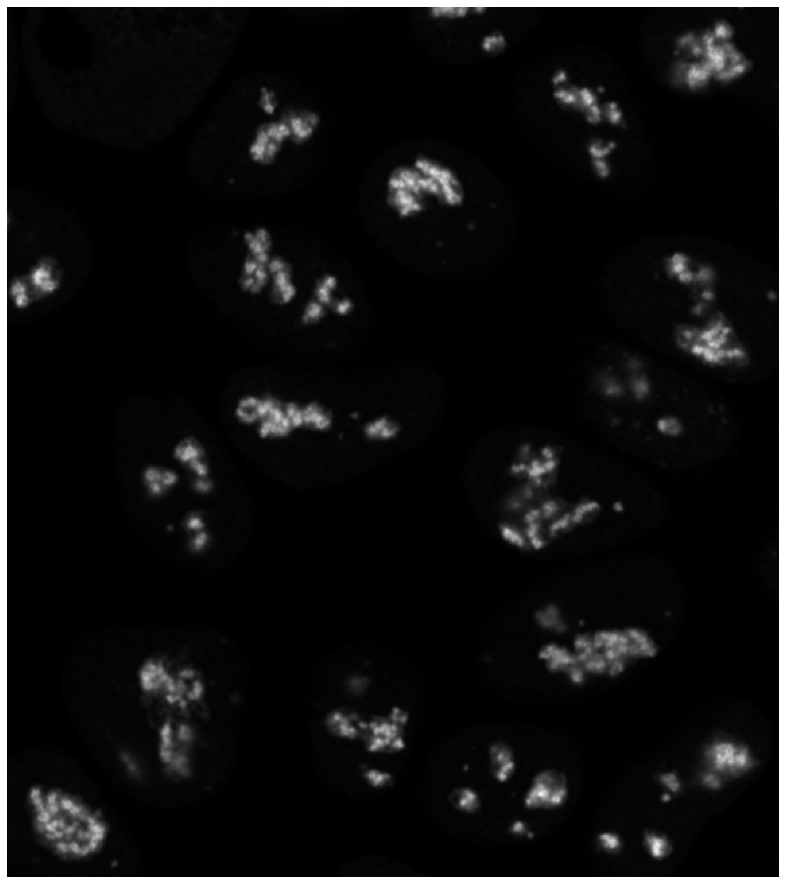

In [9]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [10]:
#####################
structure_channel = 0
#####################

structure_img0 = IMG[0,structure_channel,:,:,:]
view(single_fluorescent_view(structure_img0))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f7660237e…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**

Parameter for fibrillarin:  `intensity_scaling_param = [0.5, 18]`

Parameter for beta catenin:  `intensity_scaling_param = [4, 27]`

About this parameter `intensity_scaling_param = [A, B]`: Here, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be.
 

* **Smoothing** 

3D gaussian smoothing with `gaussian_smoothing_sigma = 1`.

About `gaussian_smoothing_sigma`: The large the value is, the more the image will be smoothed. 

In [17]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [0, 32]
gaussian_smoothing_sigma = 3
################################
# intensity normalization
structure_img = intensity_normalization(structure_img0, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_3d(structure_img, sigma=gaussian_smoothing_sigma)

In [16]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f762be688…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = ` 

In [11]:
from aicssegmentation.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(structure_img0)

mean intensity of the stack: 51.96920848404923
the standard deviation of intensity of the stack: 273.7940293388762
0.9999 percentile of the stack intensity is: 6025.0
minimum intensity of the stack: 0
maximum intensity of the stack: 8466
suggested upper range is 22.0, which is 6075.437853939326
suggested lower range is 0.0, which is 51.96920848404923
So, suggested parameter for normalization is [0.0, 22.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [12]:
structure_img0.min()

0

### Step 2: Core Algorithm

#### apply 2d spot filter 

Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated radius of your target spotty shape. For example, if visually the diameter of the spotty objects is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have objects of very different sizes.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf fatter segmentation, while larger `cutoff_x` could be less permisive and yield less objects and slimmer segmentation. 

Parameter for fibrillarin:  `s2_param = [[1, 0.01]]`

Parameter for beta catenin:  `s2_param = [[1.5, 0.01]]`

In [18]:
from scipy import ndimage as ndi

In [20]:
log_sigma = 3
zz = 40
r = -1*(log_sigma**2)*ndi.filters.gaussian_laplace(structure_img_smooth[zz, :, :], log_sigma)

In [23]:
b = r>0.01
b = b.astype(np.uint8)
view(b)

Viewer(rendered_image=<itkImagePython.itkImageUC2; proxy of <Swig Object of type 'itkImageUC2 *' at 0x7f75c00c…

In [7]:
################################
## PARAMETERS for this step ##
s2_param = [[1, 0.01]]
################################

bw = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)

In [9]:
viewer_bw = view(segmentation_quick_view(bw))
viewer_bw

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side
##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [10]:
# Option 1:
# view(seg_fluo_side_by_side(structure_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
view(seg_fluo_side_by_side(structure_img,bw,roi=['M',[570,370,730,440]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

##### Is the segmentation satisfactory? Here are some possible criteria:

* Is there any spot should be detected but not? Try to reduce `cutoff_x`
* Is there any object should not be detected but actually appear in the result? Try to increase `cutoff_x` or try a larger `scale_x`
* Is the segmented size of the spots fatter than it should be? Try to increase `cutoff_x` or try a smaller `scale_x`
* Is there any spot that should be solid but segmented as a ring? Try to increase `scale_x`
* Are you observing spots with very different sizes? Try multiple sets of `scale_x` and `cutoff_x` 

#### Step 3: Post-Processing 

In [11]:
################################
## PARAMETERS for this step ##
minArea = 5
################################

final_seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [12]:
viewer_final = view(segmentation_quick_view(final_seg))
viewer_final

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

### You can also focus your inspection on a small ROI

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [14]:
# Option 1: 
# view(seg_fluo_side_by_side(structure_img, final_seg, roi=['ROI',viewer_final.roi_slice()]))

# Option 2: 
view(seg_fluo_side_by_side(structure_img, final_seg, roi=['M',[267,474, 468, 605]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

### You may also physically save the segmentation results into a .tiff file

In [16]:
final_seg = final_seg >0
out=final_seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('../../data/FBL/result/3500001486_100X_20171031_5-Scene-1-P18-F08_test_segmentation.tiff')
writer.save(out)